In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime

from scipy.stats.mstats import gmean

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read data

In [2]:
raw_data = pd.read_excel('data/RawData.xlsx') #Read the raw data

#Divide into the various taxonomic groups
raw_data.loc[raw_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
raw_data.loc[raw_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
raw_data.loc[raw_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
raw_data.loc[raw_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
raw_data.loc[raw_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

#combining canopy into above ground habitat
raw_data.loc[raw_data['aggregated environment']=='canopy','aggregated environment'] = 'above ground'

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Count the number of datapoints of the various types

In [3]:
print('Number of unique sites according to units used: \n%s' % raw_data.groupby('units').site.nunique())
print('\nNumber of unique sites in common to both units systems (poppulation and biomass): \n%s' % raw_data[raw_data.units.str.startswith('ind')].merge(raw_data[raw_data.units.str.startswith('mg')],how='inner',on='site').site.nunique())
print('\nNumber of unique sites according to taxonomic group: \n%s' % raw_data.groupby('aggregated taxon').site.nunique())

Number of unique sites according to units used: 
units
individuals/m^2        325
mg/m^2 (dry weight)    275
mg/m^2 (wet weight)    115
Name: site, dtype: int64

Number of unique sites in common to both units systems (poppulation and biomass): 
219

Number of unique sites according to taxonomic group: 
aggregated taxon
Acari         205
Collembola    186
Formicidae    113
Isoptera      144
Other         231
Name: site, dtype: int64


### Define functions to derive the sampling years of the datapoints

In [4]:
##get the years specified in a reported measurement, element-wise
def getYear(x): 
    if isinstance(x, datetime.datetime) :
        return [x.year]
    elif isinstance(x, int):
        return [x]
    elif isinstance(x, str):
        x = x.replace(" ","")
        if len(x)<=10 and '/' in x :
            d1 = datetime.datetime.strptime(x, '%d/%m/%Y')
            return [d1.year]
        elif '-' in x and '/' in x :
            D = x.split('-',2)
            d1 = datetime.datetime.strptime(D[0], '%d/%m/%Y')
            d2 = datetime.datetime.strptime(D[1], '%d/%m/%Y')
            return np.arange(d1.year,d2.year+1)
        elif '-' in x :
            D = x.split('-',2)
            d1 = datetime.datetime.strptime(D[0], '%Y')
            d2 = datetime.datetime.strptime(D[1], '%Y')
            return np.arange(d1.year,d2.year+1)
        else:
            return np.nan
    else: 
        return np.nan 

## count the sampling years for the various sites in a certain array x:
def sum_dates(x): 
    sites = x['site'].unique() #create a list of the unique sites
    dates_per_site = [x[x.loc[:,'site']== site].date for site in sites] #list of dates per each site in the list above
    
    years = [] #initialise
    counts = [] #initialise
    for site in dates_per_site: #work site-wise
        yrs = [getYear(date) for date in site] #get all years for a single site
        yrs_flat = [item for sublist in yrs for item in sublist] #flatten the yrs array
        years_tmp, counts_tmp = np.unique(yrs_flat, return_counts=True) #list the sampling years in a certain site
        prcnt = counts_tmp/len(yrs_flat) #the percentage it takes of the measurements 
        years = np.concatenate((years ,years_tmp)) #add to the list of years
        counts = np.concatenate((counts ,prcnt)) #add to the list of counts per year

    U_years = np.unique(years[years>0]) #list of unique years in the entire array x
    U_counts = [np.sum(counts[years==year]) for year in U_years] #list of total number of counts per each year in U_years
    return U_years, U_counts

#plot the data in a bar plot histogram
def PlotBar_av(x,title,letter,ax,Xlabel,Ylabel,Color='#607c8e'):
    
    years, counts = sum_dates(x)
    plt.bar(years, counts, align='center',color=Color)
    ax.text(0.05,0.92,letter,ha='center',va='center',fontdict={'size':18},transform = ax.transAxes)
    ax.text(0.96,0.96,title,ha='right',va='top',fontdict={'size':18},transform = ax.transAxes)
    plt.xlabel(Xlabel, size = 20)
    plt.ylabel(Ylabel, size = 20)
#    plt.grid(axis='y', alpha=0.5)
    plt.xlim([minYear-1,maxYear+1])
    plt.ylim([0,45])

    
def PlotBar_av_2(x,title,letter,ax,Xlabel,Ylabel,Color='#607c8e',legend=False):  #_2 is for the two habitat types

    ColH=['#945200','#009B00'] #'#008F00' #38B124
    years = x.index
    soil = x['soil/litter'].values
    above = x['above ground'].values 

    plt.bar(years, soil, align='center',label = 'Soil', color=Color)
    plt.bar(years, above, align='center',label = 'Above Ground', bottom = soil, color=ColH[1])
        
    ax.text(0.05,0.92,letter,ha='center',va='center',fontdict={'size':18},transform = ax.transAxes)
    ax.text(0.96,0.96,title,ha='right',va='top',fontdict={'size':18},transform = ax.transAxes)
    plt.xlabel(Xlabel, size = 20)
    plt.ylabel(Ylabel, size = 20)
#    plt.grid(axis='y', alpha=0.5)
    plt.xlim([minYear-1,maxYear+1])
    plt.ylim([0,45])
    
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [1,0]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right',frameon=False,prop={'size': 12})#loc=[0.007,0.47]
    
    
#extract data for a certain aggregated taxon and environment
def taxon_data(x = raw_data, env = 'soil/litter', taxon = 'All'):
    if taxon == 'All': #take all taxa
        data =  x[(x['aggregated environment']==env)]
    else: #take a specific taxonomic group
        data = x[(x['aggregated environment']==env) & (x['aggregated taxon']==taxon)]
    return data


def pd_get_years_data_taxon(x,env,taxon):
    data = taxon_data(x, env, taxon)
    years, counts = sum_dates(data)
    df = pd.DataFrame(counts,index=years.astype(int),columns=[env])
    return df

def taxon_data_2(taxon): #currently not being used
    soil_df = pd_get_years_data_taxon(raw_data,'soil/litter',taxon)
    above_df = pd_get_years_data_taxon(raw_data,'above ground',taxon)

    all_df = soil_df.reset_index().merge(above_df.reset_index(), how='outer',on='index').set_index('index')
    all_df[all_df.isna()]=0
    return all_df

U_years,_ = sum_dates(raw_data)

maxYear = np.max(U_years)
minYear = np.min(U_years)

print('Dates range: {minYear} - {maxYear}'.format(minYear=minYear, maxYear=maxYear))

Dates range: 1944.0 - 2016.0


### Plot the data

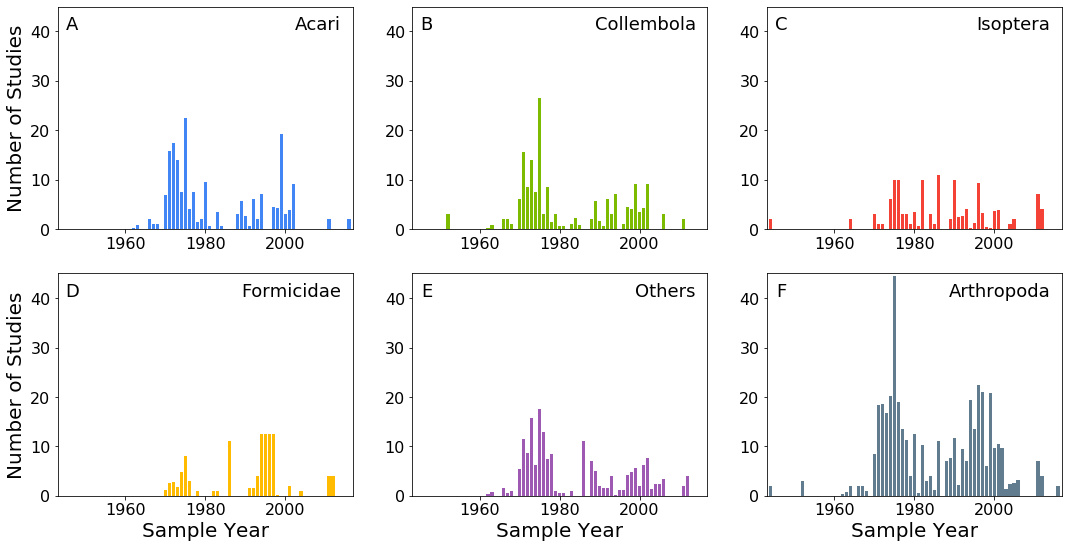

In [5]:
#plot in soil only (figure S1)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
    
fig = plt.subplots(2,3,figsize = (18,9))

Colors = ['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3']
ax = plt.subplot(2,3,1)
PlotBar_av(taxon_data(taxon = 'Acari'),'Acari','A',ax,'','Number of Studies',Colors[0])
ax = plt.subplot(2,3,2)
PlotBar_av(taxon_data(taxon = 'Collembola'),'Collembola','B',ax,'','',Colors[1])
ax = plt.subplot(2,3,3)
PlotBar_av(taxon_data(taxon = 'Isoptera'),'Isoptera','C',ax,'','',Colors[3])
ax = plt.subplot(2,3,4)
PlotBar_av(taxon_data(taxon = 'Formicidae'),'Formicidae','D',ax,'Sample Year','Number of Studies',Colors[2])
ax = plt.subplot(2,3,5)
PlotBar_av(taxon_data(taxon = 'Other'),'Others','E',ax,'Sample Year','',Colors[4])
ax = plt.subplot(2,3,6)
PlotBar_av(taxon_data(taxon = 'All'),'Arthropoda','F',ax,'Sample Year','',Color='#607c8e')

plt.savefig('results/figs/S1 - time_comb_SI.pdf',dpi=300,bbox_inches = "tight") ##
plt.savefig('results/figs/png/S1 - time_comb_SI.png',dpi=300,bbox_inches = "tight") ##

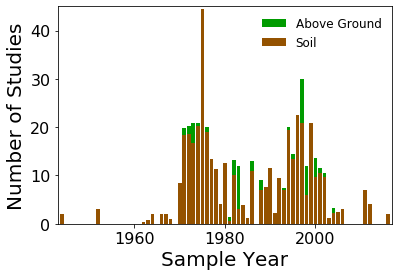

In [6]:
#plot all arthropods in both habitats (figure 1B)
soil_df = pd_get_years_data_taxon(raw_data,'soil/litter',taxon='All')
above_df = pd_get_years_data_taxon(raw_data,'above ground',taxon='All')

all_df = soil_df.reset_index().merge(above_df.reset_index(), how='outer',on='index').set_index('index')

fig, ax = plt.subplots()
PlotBar_av_2(all_df,'','',ax,'Sample Year','Number of Studies',Color='#945200',legend=True)

plt.savefig('results/figs/locations and times/time_comb_all.pdf',dpi=300,bbox_inches = "tight") ##

In [7]:
raw_data.groupby('aggregated environment').site.nunique()

aggregated environment
above ground     54
soil/litter     444
Name: site, dtype: int64